# **Patronising and Condescending Language (PCL)** Text Classification

## 1. **Dataset Analysis**

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

In [28]:
# Load labelled data data
label_data_cols = ['id', 'article_id', 'keyword', 'country_code', 'text', 'label']
label_train_data = pd.read_csv('data/train/original_data/dontpatronizeme_pcl.tsv', skiprows=3, sep='\t', header=None)
label_train_data.columns = label_data_cols

label_train_data.head()

,id,article_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0


In [29]:
# Add column for text length
text_lengths = label_train_data.apply(lambda x: len(str(x['text'])), axis=1)
label_train_data['text_length'] = text_lengths
label_data_cols.append('text_length')

label_train_data.head()

,id,article_id,keyword,country_code,text,label,text_length
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,620
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,237
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,158
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,162
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,273


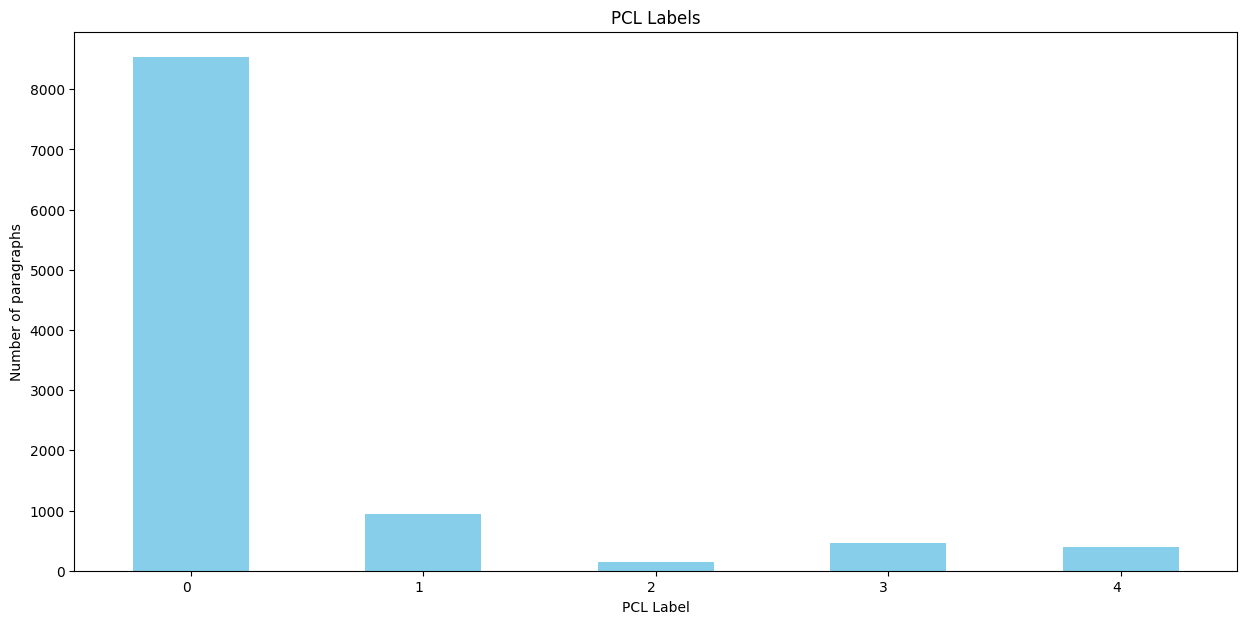

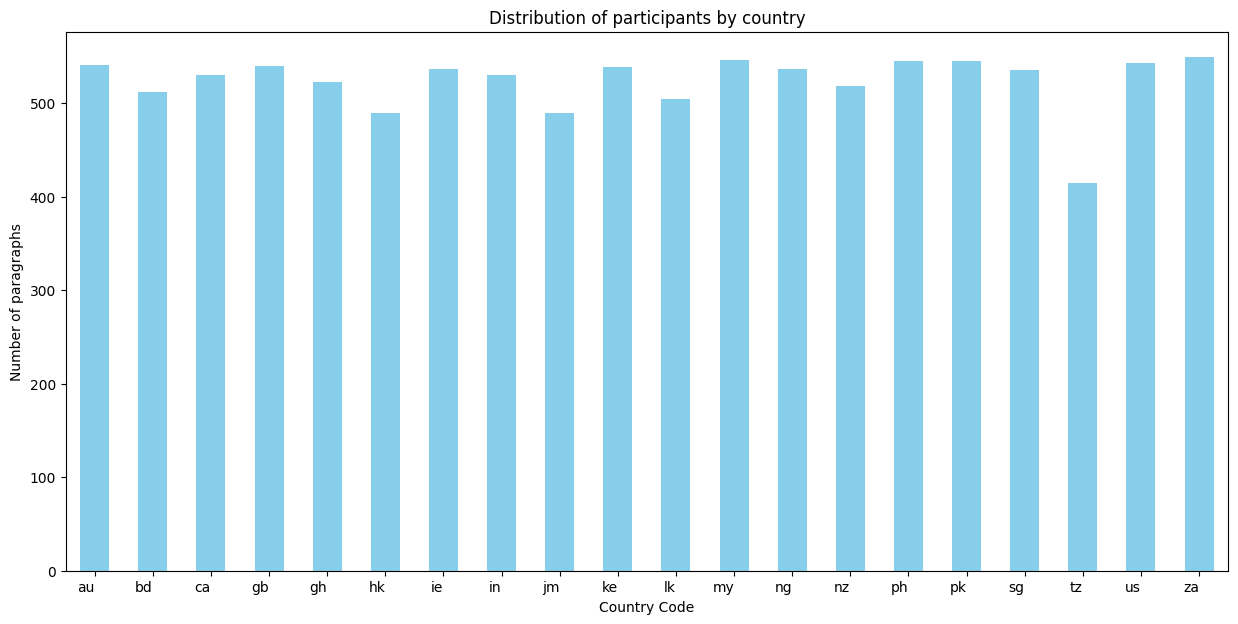

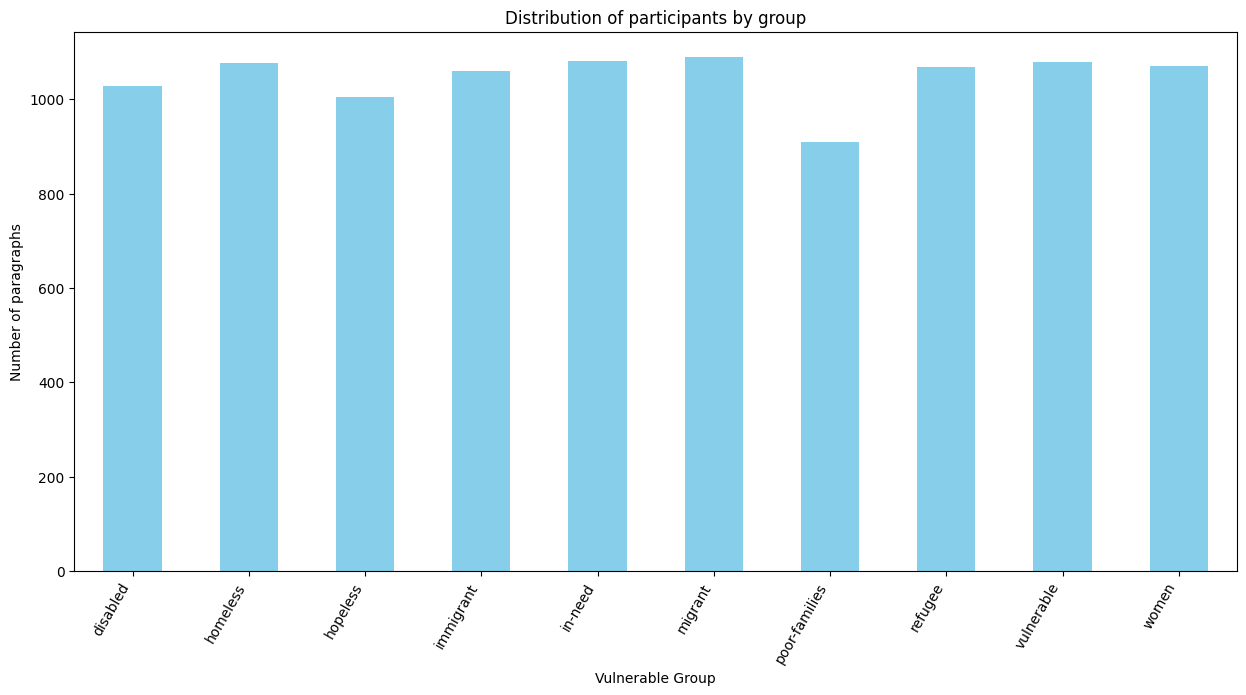

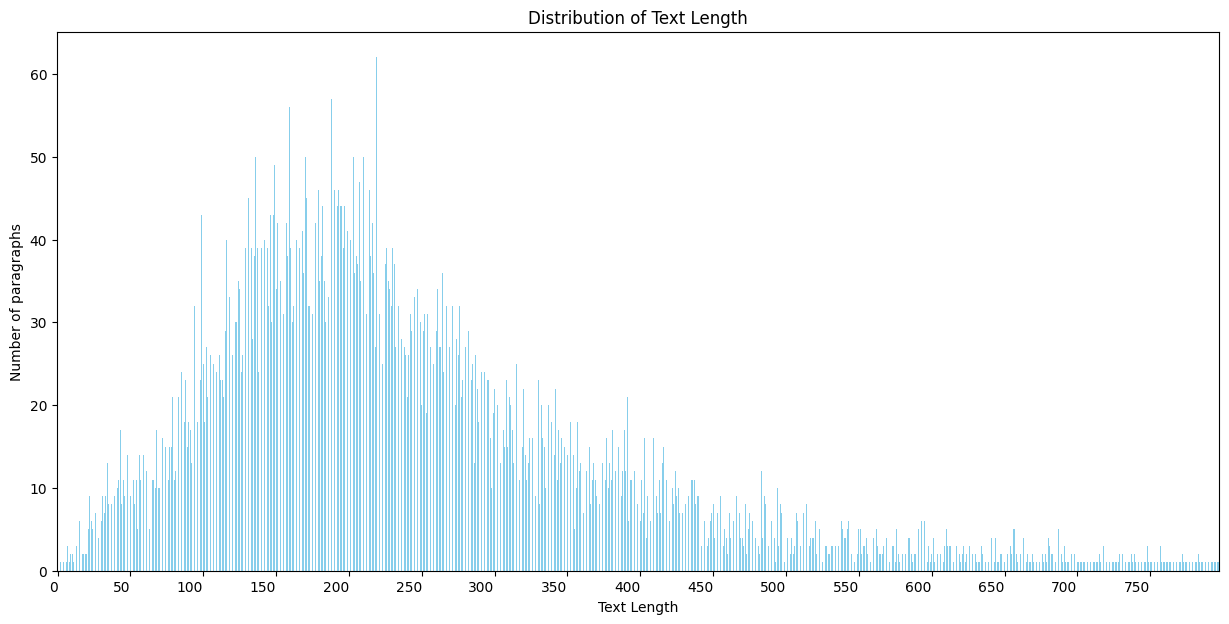

In [30]:
def plot_data_distribution(data, column, title, x_label, data_order=None, save=False, plot_name='', rotation=0):
    """
    Plot the distribution of the data for the specified column against the number of articles.
    Params:
        - data (DataFrame): the data to plot
        - column (str): the column to plot
        - title (str): the plot title
        - x_label (str): the x-axis label
        - save (bool): whether to save the plot locally or not (default=False)
        - plot_name (str): the name to save the plot as (default='')
        - rotation (int): the rotation of the x-axis labels (default=0)
    """
    fig, ax = plt.subplots(figsize=(15, 7))

    if not data_order:
        data_to_plot = data[column].value_counts().sort_index()
    else:
        data_to_plot = data[column].value_counts()[data_order]
    data_to_plot.plot(kind='bar', color='skyblue')

    x_ticks = list(data_to_plot.index)
    if type(x_ticks[0]) == str:
        ax.set_xticks(range(len(x_ticks)))
    if len(list(data[column].value_counts().index)) > 20:
        x_ticks = [i for i in range(len(x_ticks)) if i % 50 == 0]
        ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=rotation, ha='right')
    
    plt.title(title)
    plt.ylabel('Number of paragraphs')
    plt.xlabel(x_label)
    if save:
        fig_name = f"plots/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf", bbox_inches='tight')
    plt.show()

# Plot Train Data Statistics
plot_data_distribution(label_train_data, 'label', title='PCL Labels', x_label='PCL Label', save=True, plot_name='pcl_labels_distribution')
plot_data_distribution(label_train_data, 'country_code', title='Distribution of participants by country', x_label='Country Code', save=True, plot_name='country_distribution')
plot_data_distribution(label_train_data, 'keyword', title='Distribution of participants by group', x_label='Vulnerable Group', save=True, plot_name='group_distribution', rotation=60)
plot_data_distribution(label_train_data, 'text_length', title='Distribution of Text Length', x_label='Text Length' , save=True, plot_name='text_length_distribution')

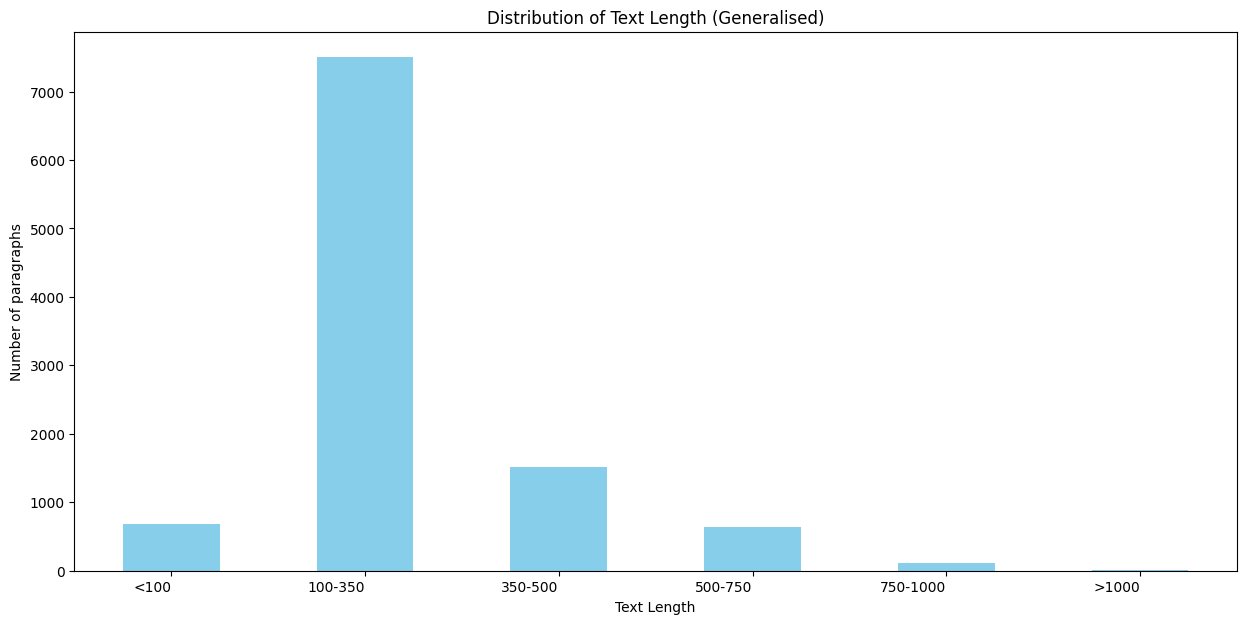

,id,article_id,keyword,country_code,text,label,text_length
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,500-750
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,100-350
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,100-350
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,100-350
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,100-350


In [31]:
# Generalise text lengths
def generalise_length(x):
    if x < 100:
        return '<100'
    elif x < 350:
        return '100-350'
    elif x < 500:
        return '350-500'
    elif x < 750:
        return '500-750'
    elif x < 1000:
        return '750-1000'
    else:
        return '>1000'

generalised_data = label_train_data.copy()
generalised_data['text_length'] = generalised_data['text_length'].apply(generalise_length)
article_lengths_order = ['<100', '100-350', '350-500', '500-750', '750-1000', '>1000']
plot_data_distribution(generalised_data, 'text_length', title='Distribution of Text Length (Generalised)', x_label='Text Length', data_order=article_lengths_order, save=True, plot_name='text_length_generalised_distribution')
generalised_data.head()

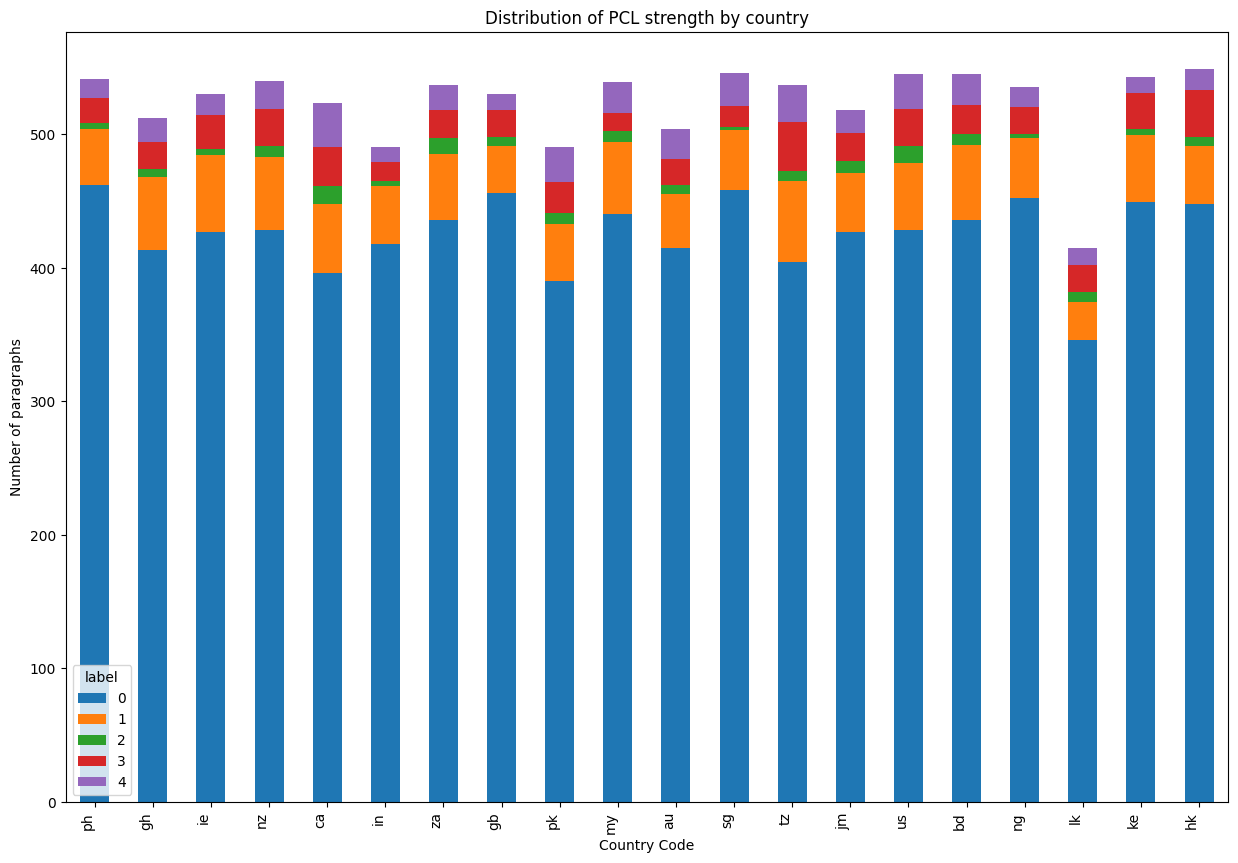

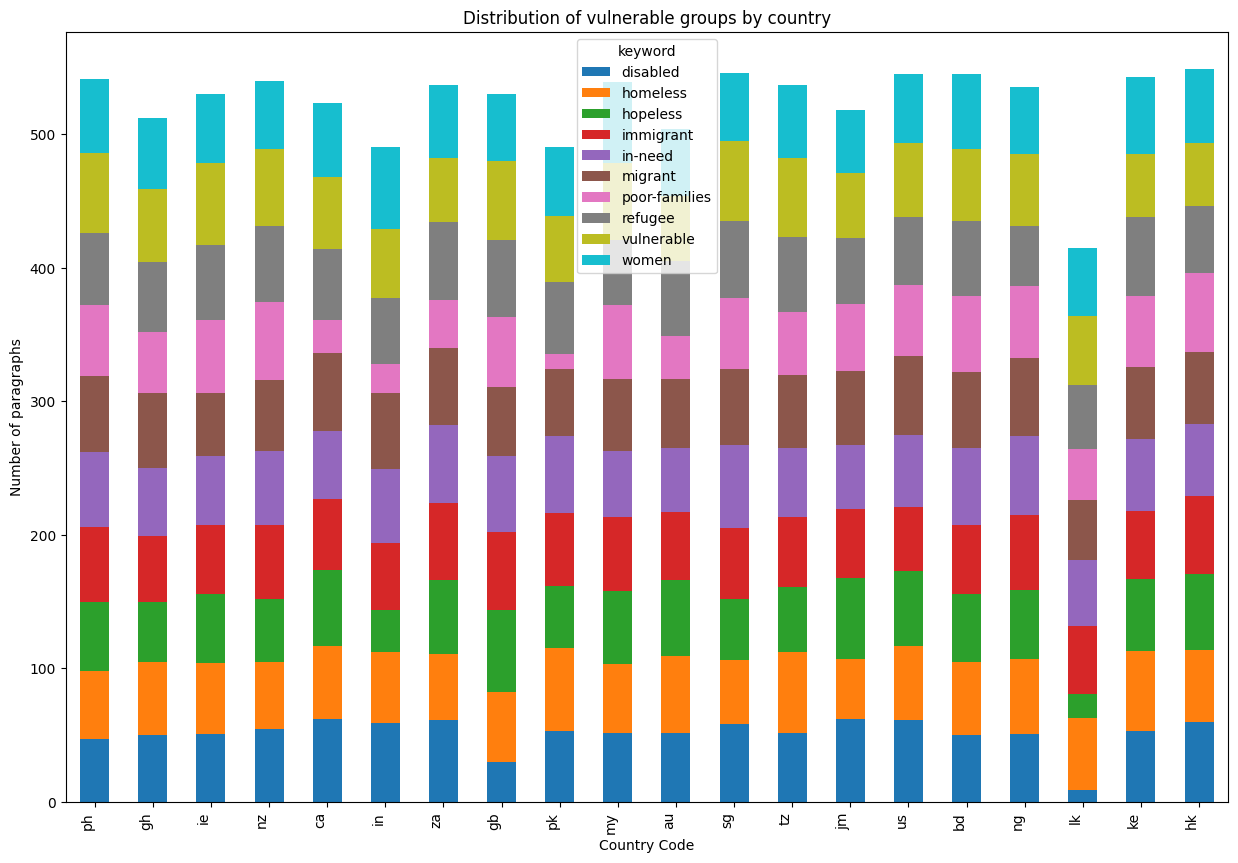

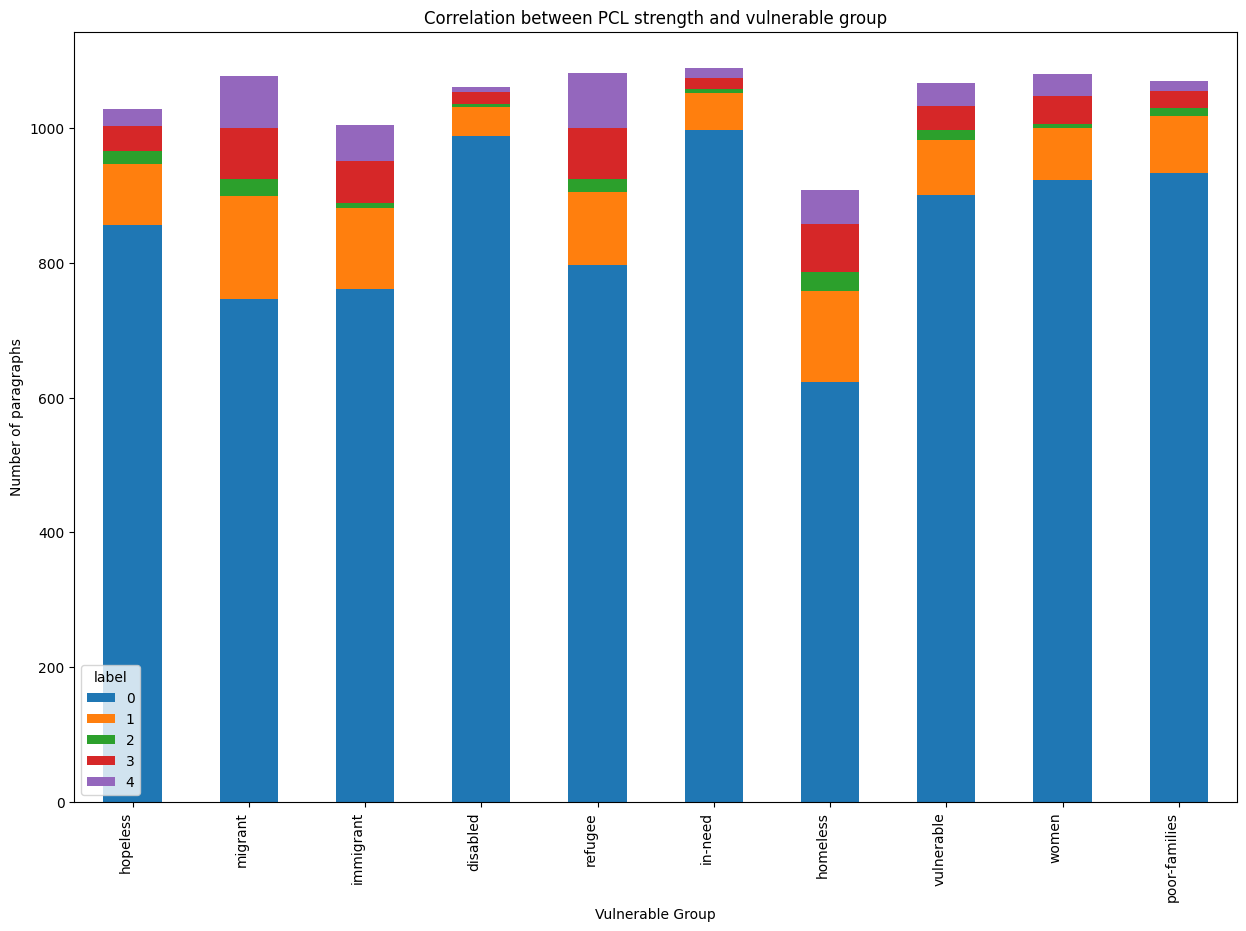

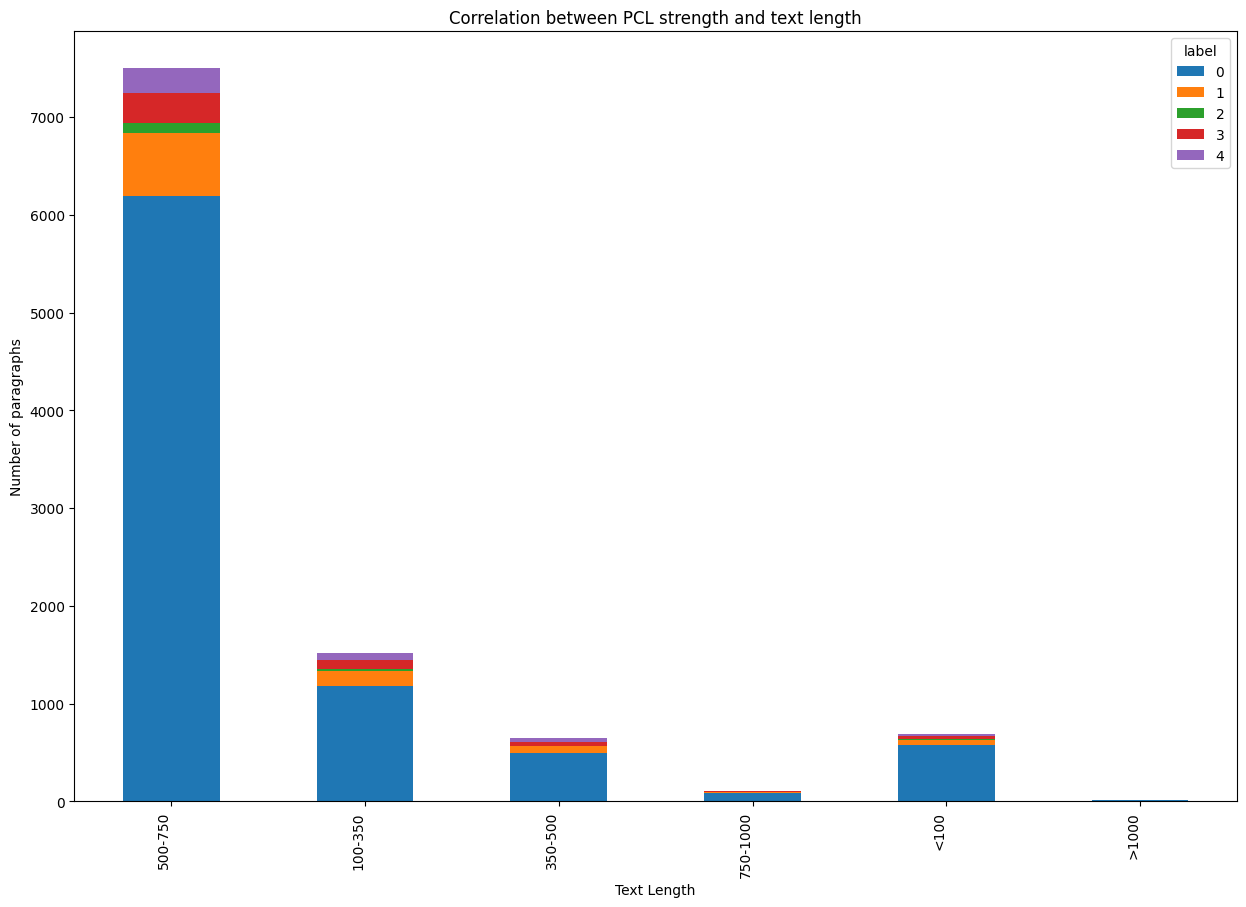

In [32]:
def plot_data_correlation(data, x_col, y_col, x_label, y_label, title, data_order=None, save=False, plot_name=''):
    """
    Plot the correlation between different data columns in the dataset.
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    
    if not data_order:
        data_to_plot = data.groupby(x_col)[y_col].value_counts().sort_index()
    else:
        data_to_plot = data.groupby(x_col)[y_col].value_counts()[data_order]
    data_to_plot.unstack().plot(kind='bar', stacked=True, ax=ax)

    x_ticks = list(data[x_col].unique())
    if type(x_ticks[0]) == str:
        ax.set_xticks(range(len(x_ticks)))
    else:
        ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, ha='right')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save:
        fig_name = f"plots/{plot_name}.pdf"
        plt.savefig(fig_name, format="pdf", bbox_inches='tight')
    plt.show()

plot_data_correlation(generalised_data, 'country_code', 'label', 'Country Code', 'Number of paragraphs', 'Distribution of PCL strength by country', save=True, plot_name='pcl_distribution_by_country')
plot_data_correlation(generalised_data, 'country_code', 'keyword', 'Country Code', 'Number of paragraphs', 'Distribution of vulnerable groups by country', save=True, plot_name='keyword_distribution_by_country')
plot_data_correlation(generalised_data, 'keyword', 'label', 'Vulnerable Group', 'Number of paragraphs', 'Correlation between PCL strength and vulnerable group', save=True, plot_name='pcl_by_keyword')
plot_data_correlation(generalised_data, 'text_length', 'label', 'Text Length', 'Number of paragraphs', 'Correlation between PCL strength and text length', data_order=article_lengths_order, save=True, plot_name='pcl_distribution_by_text_length')

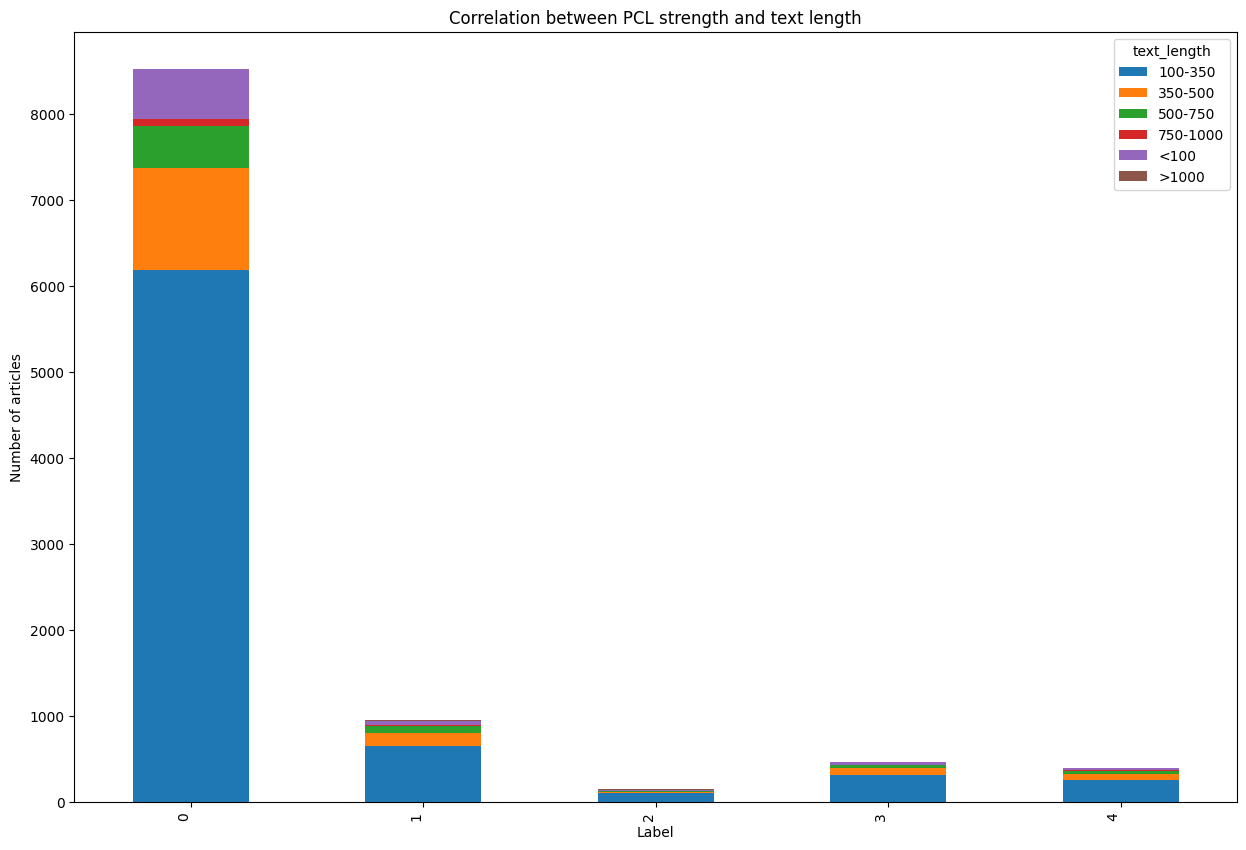

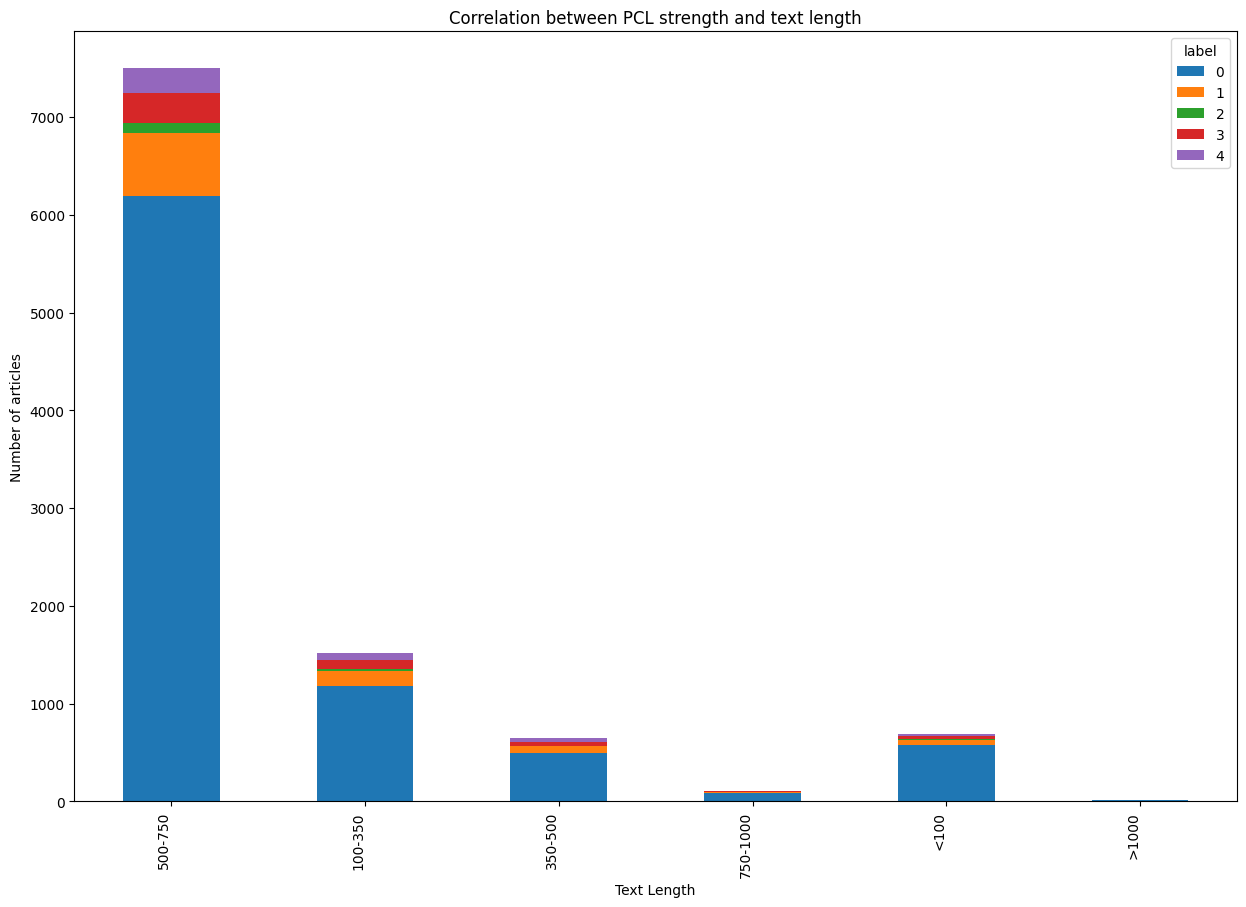

In [16]:
plot_data_correlation(generalised_data, 'label', 'text_length', 'Label', 'Number of articles', 'Correlation between PCL strength and text length', data_order=[0,1,2,3,4], save=True, plot_name='pcl_text_length_correlation')
plot_data_correlation(generalised_data, 'text_length', 'label', 'Text Length', 'Number of articles', 'Correlation between PCL strength and text length', data_order=article_lengths_order, save=True, plot_name='text_length_pcl_correlation')

In [17]:
for k in label_train_data['keyword'].unique():
    print(f"Count for US participants in group '{k}': ", end='')
    print(label_train_data[(label_train_data['keyword']==k) & (label_train_data['country_code']=='us')].count()['id'])

print("\n")

for pcl in label_train_data['label'].unique():
    print(f"Count for US articles with '{pcl}' category: ", end='')
    print(label_train_data[(label_train_data['label']==pcl) & (label_train_data['country_code']=='us')].count()['id'])

Count for US participants in group 'hopeless': 54
Count for US participants in group 'migrant': 54
Count for US participants in group 'immigrant': 51
Count for US participants in group 'disabled': 53
Count for US participants in group 'refugee': 59
Count for US participants in group 'in-need': 54
Count for US participants in group 'homeless': 60
Count for US participants in group 'vulnerable': 47
Count for US participants in group 'women': 58
Count for US participants in group 'poor-families': 53


Count for US articles with '0' category: 449
Count for US articles with '1' category: 50
Count for US articles with '2' category: 5
Count for US articles with '3' category: 27
Count for US articles with '4' category: 12


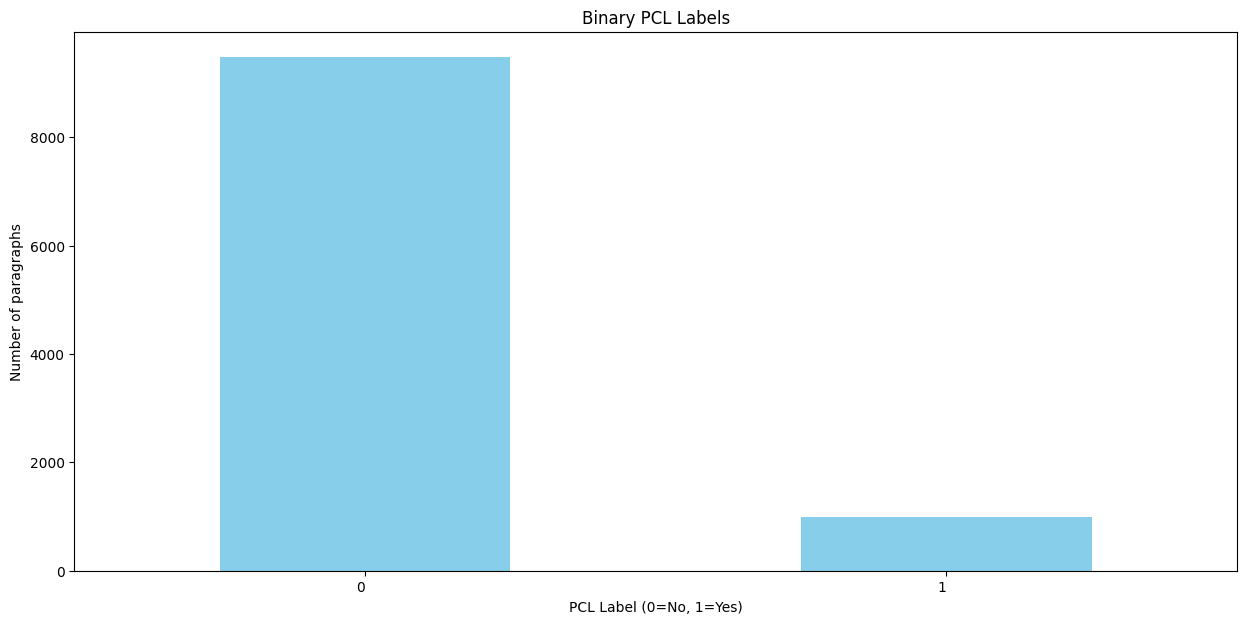

In [33]:
# Transform labels into binary classes, following the specifications in the paper
binary_labels_data = label_train_data.copy()
binary_labels_data['label'] = binary_labels_data['label'].apply(lambda x: 0 if x in [0, 1] else 1)

plot_data_distribution(binary_labels_data, 'label', title='Binary PCL Labels', x_label='PCL Label (0=No, 1=Yes)', save=True, plot_name='binary_labels_distribution')
binary_labels_data.to_csv('data/train/dontpatronizeme_pcl_binary.tsv', sep='\t', index=False, header=label_data_cols)


## 2. **Data pre-processing for model prediction**

Follows the preprocessing pipeline described in the original paper.

In [5]:
from dont_patronize_me import DontPatronizeMe
import pandas as pd
from sklearn.utils import shuffle

dpm = DontPatronizeMe('data/original_data/train', 'data/original_data/train')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

# Load paragraph IDs for training and official dev set
train_df = pd.read_csv('data/original_data/sample_splits/train_semeval_parids-labels.csv')
test_df = pd.read_csv('data/original_data/sample_splits/dev_semeval_parids-labels.csv')
train_df.par_id = train_df.par_id.astype(str)
test_df.par_id = test_df.par_id.astype(str)

data = dpm.train_task1_df

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
def prepare_dataset(data, df):
    rows = []
    for idx in range(len(df)):
        par_id = df.par_id[idx]
        keyword = data.loc[data.par_id == par_id].keyword.values[0]
        text = data.loc[data.par_id == par_id].text.values[0]
        label = data.loc[data.par_id == par_id].label.values[0]
        rows.append({
            'par_id': par_id,
            'community': keyword,
            'text': text,
            'label': label
        })
    return pd.DataFrame(rows)


# prepare train set
train_data = prepare_dataset(data, train_df)

# Prepend the community label as an extra feature to the text
train_data['text'] = train_data['community'] + ": " + train_data['text']
# add text length feature
train_data['text_length'] = train_data.apply(lambda x: len(str(x['text'])), axis=1)
print("Train set shape:", train_data.shape)

# Adjust class balance (for binary Task 1: treat label==1 as positive, label==0 as negative)
# Downsample negatives to get a ~1:3 ratio with the positive (PCL) class.
positive_pcl = train_data[train_data.label == 1]
balanced_df = pd.concat([positive_pcl, train_data[train_data.label == 0][:len(positive_pcl) * 3]])
balanced_df = shuffle(balanced_df, random_state=42)
print("Balanced training set shape:", balanced_df.shape)

Train set shape: (8375, 5)
Balanced training set shape: (3176, 5)


In [ ]:
# prepare test set
test_data = prepare_dataset(data, test_df)

# Prepend community label to text in dev set as well
test_data['text'] = test_data['community'] + ": " + test_data['text']
# add text length feature
test_data['text_length'] = test_data.apply(lambda x: len(str(x['text'])), axis=1)
print("Test set shape:", test_data.shape)

Test set shape: (2094, 5)


In [9]:
# save to .csv fiile for model
train_data.to_csv('data/preprocessed_data/train.csv', index=False)
test_data.to_csv('data/preprocessed_data/dev.csv', index=False)
balanced_df.to_csv('data/preprocessed_data/train_balanced.csv', index=False)